In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install fastai --upgrade
from fastai.vision.all import *

     |████████████████████████████████| 187 kB 584 kB/s eta 0:00:01
     |████████████████████████████████| 42 kB 337 kB/s eta 0:00:01
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.0.13
    Uninstalling fastcore-1.0.13:
      Successfully uninstalled fastcore-1.0.13
  Attempting uninstall: fastai
    Found existing installation: fastai 2.0.13
    Uninstalling fastai-2.0.13:
      Successfully uninstalled fastai-2.0.13


In [2]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.basics import *

In [3]:
path = Path('../input/covid19-radiography-database/COVID-19 Radiography Database')

In [4]:
path.ls()

(#7) [Path('../input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL.metadata.xlsx'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/README.md.txt'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'),Path('../input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia.matadata.xlsx')]

In [5]:
files = get_image_files(path)

In [6]:
len(files)

2905

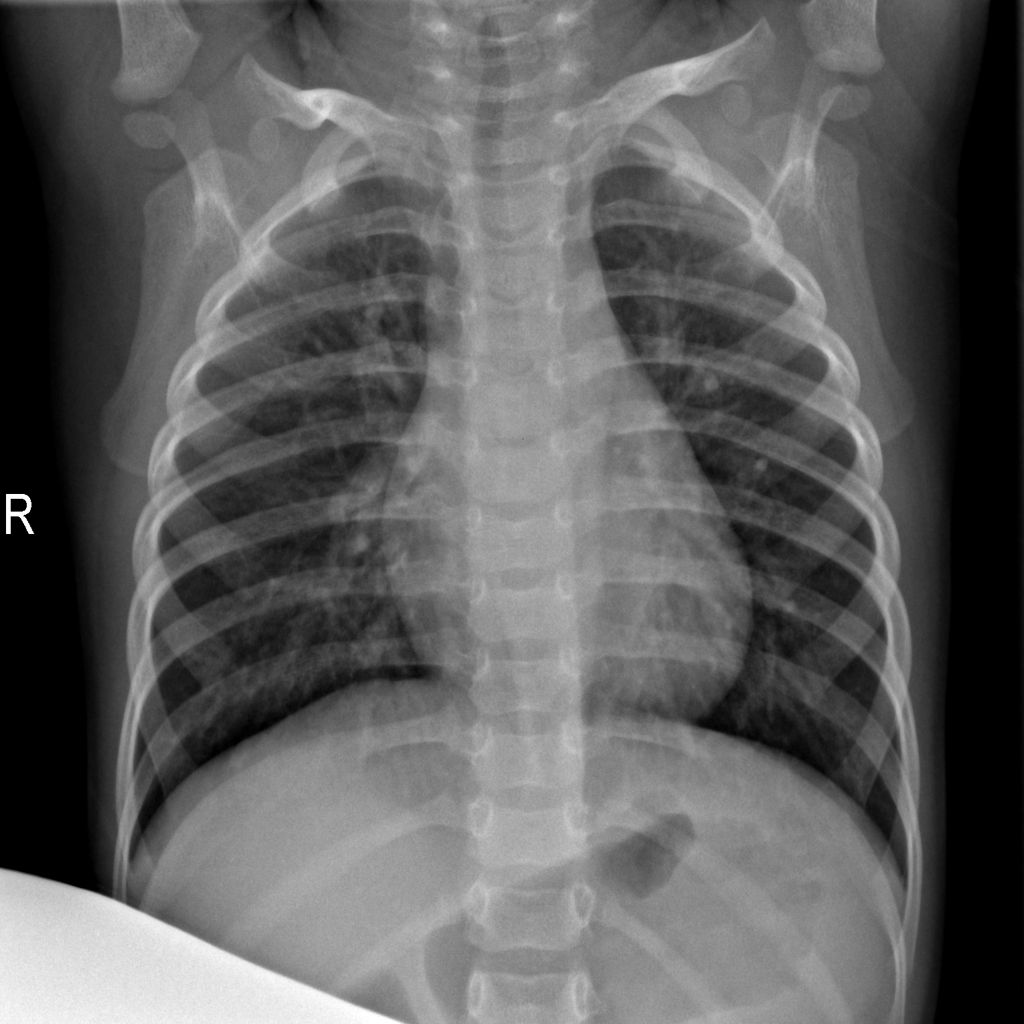

In [7]:
import PIL
img = PIL.Image.open(files[0])
img

In [8]:
import torch
import numpy as np

def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

open_image(files[0]).shape



torch.Size([3, 224, 224])

In [9]:
import re
def label_func(fname):
    return fname.parent.name

In [10]:
files[0]

Path('../input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL/NORMAL (535).png')

In [11]:
label_func(files[0])

'NORMAL'

In [12]:
labels = list(set(files.map(label_func)))
len(labels)

3

In [13]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [14]:
import random

class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [15]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [16]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [17]:
from fastai.data.core import DataLoaders

In [18]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [19]:
b = dls.one_batch()
dls = dls.cuda()

In [20]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [21]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [22]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [23]:
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [24]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [25]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [26]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [27]:
metrics = [accuracy, F1Score(), Precision(), Recall()]

In [28]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=metrics)

In [29]:
learn.freeze()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0010000000474974513)

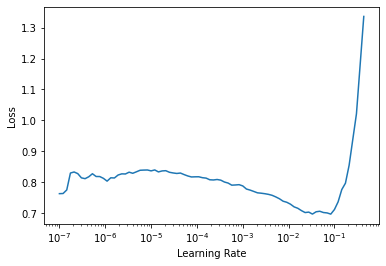

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.638302,0.497619,0.790017,0.790378,0.766667,0.815603,02:07
1,0.453471,0.356982,0.850258,0.831721,0.914894,0.762411,02:03
2,0.318494,0.174212,0.929432,0.927690,0.922807,0.932624,02:00
3,0.232047,0.164630,0.936317,0.934281,0.935943,0.932624,02:02


In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.156870,0.155905,0.938038,0.935484,0.945652,0.925532,02:04
1,0.140443,0.148560,0.944923,0.942446,0.956204,0.929078,02:01
2,0.133341,0.144180,0.943201,0.940541,0.956044,0.925532,02:02
3,0.134303,0.137159,0.946644,0.944345,0.956364,0.932624,02:01


In [34]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

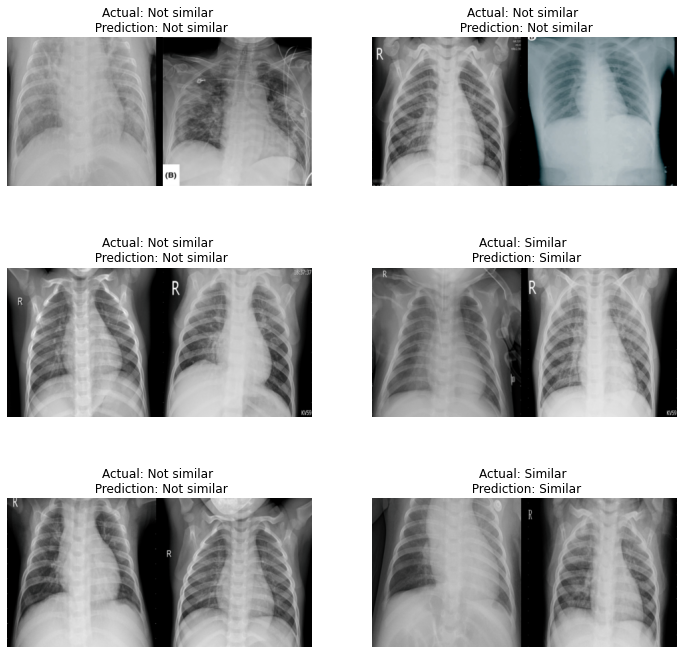

In [35]:
learn.show_results()

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix()

AttributeError: vocab